In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [2]:
file_path = "training.xlsx"
df = pd.read_excel(file_path)
df.head()

,Date,Vehicle Category,GVWR Class,Fuel Type,Model Year,Fuel Technology,Electric Mile Range,Number of Vehicles Registered at the Same Address,Region,Vehicle Population
0,2019,P,Not Applicable,Gasoline,2020.0,ICE,Not Applicable,≥4,Statewide,395883
1,2020,P,Not Applicable,Gasoline,2020.0,ICE,Not Applicable,1,Statewide,370954
2,2021,P,Not Applicable,Gasoline,2020.0,ICE,Not Applicable,1,Statewide,349406
3,2019,P,Not Applicable,Gasoline,2019.0,ICE,Not Applicable,≥4,Statewide,348475
4,2019,P,Not Applicable,Gasoline,2018.0,ICE,Not Applicable,≥4,Statewide,333296


In [3]:
columns_to_drop = ["Region"]
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned[df_cleaned['Fuel Type'] != 'Unknown'].reset_index(drop=True)
df_cleaned = df_cleaned[df_cleaned['Number of Vehicles Registered at the Same Address'] != 'Unknown'].reset_index(drop=True)
df_cleaned["Year Diff"] = df_cleaned["Date"] - df_cleaned["Model Year"]
df_cleaned = df_cleaned[~df_cleaned['Year Diff'].isna()].reset_index(drop=True)
df_cleaned["Number of Vehicles Registered at the Same Address"] = df_cleaned["Number of Vehicles Registered at the Same Address"].replace("≥4", 4)
df_cleaned["GVWR Class"] = df_cleaned["GVWR Class"].astype(str)
def categorize(row):
    if row == "Not Applicable":
        return "Not Applicable"
    elif row == "Unknown":
        return "Unknown"
    elif "miles" in row:
        return "Mile Range"
    else:
        return "Other"
df_cleaned["Electric Mile Encoded"] = df_cleaned["Electric Mile Range"].apply(categorize)

In [4]:
def encode_columns(dataframe, columns, drop_original=True):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_df = dataframe.copy()
    
    for column in columns:
        encoded_data = encoder.fit_transform(encoded_df[[column]])
        
        encoded_columns = pd.DataFrame(
            encoded_data, 
            columns=encoder.get_feature_names_out([column]),
            index=encoded_df.index
        )
        
        encoded_df = pd.concat([encoded_df, encoded_columns], axis=1)
        
        if drop_original:
            encoded_df = encoded_df.drop(columns=[column])
    
    return encoded_df


In [5]:
columns_to_encode = ['Fuel Type', 'Vehicle Category', 'Fuel Technology', 'GVWR Class', 'Electric Mile Encoded']

df_cleaned_encoded = encode_columns(df_cleaned, columns=columns_to_encode)

selected_columns = [col for col in df_cleaned_encoded.columns if col.startswith('Fuel Type') or col.startswith('Electric Mile Encoded') or col.startswith('Vehicle Category') or col.startswith('GVWR Class') or col.startswith('Fuel Technology') \
                    or col in ['Year Diff', 'Number of Vehicles Registered at the Same Address']]

X = df_cleaned_encoded[selected_columns]
y = df_cleaned["Vehicle Population"]

In [6]:
from xgboost import XGBRegressor

model_type = 1
regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=42, colsample_bytree = 0.7, subsample =.7)

regressor.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [7]:
test_data = pd.read_excel("scoring.xlsx")

X_test = test_data.copy() 

X_test.loc[:, "Year Diff"] = X_test["Date"] - X_test["Model Year"]
X_test.loc[:, "Year Diff"] = X_test["Year Diff"].fillna(18)
X_test["Number of Vehicles Registered at the Same Address"] = X_test["Number of Vehicles Registered at the Same Address"].replace("≥4", 4)
X_test["GVWR Class"] = X_test["GVWR Class"].astype(str)
X_test["Electric Mile Encoded"] = X_test["Electric Mile Range"].apply(categorize)

columns_to_encode = ['Fuel Type', 'Vehicle Category', 'Fuel Technology', 'GVWR Class', 'Electric Mile Encoded']

X_test_encode = encode_columns(X_test, columns=columns_to_encode)
X_test = X_test_encode[selected_columns]
y_test = test_data["Vehicle Population"]
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

rmse

6043.282342851861

In [8]:
y_pred_series = pd.Series(y_pred, name="Predicted")

view_data = pd.concat([test_data, y_pred_series], axis=1)

In [9]:
feature_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": regressor.feature_importances_
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance)

                                              Feature  Importance
12                                 Vehicle Category_P    0.168759
22                                Fuel Technology_ICE    0.119731
35               Electric Mile Encoded_Not Applicable    0.090262
4                                  Fuel Type_Gasoline    0.089837
11                                Vehicle Category_MH    0.072040
23                               Fuel Technology_PHEV    0.067154
9                                 Vehicle Category_BT    0.041215
7                                  Vehicle Category_B    0.040443
10                                Vehicle Category_MC    0.038423
32                          GVWR Class_Not Applicable    0.032644
8                                 Vehicle Category_BS    0.027435
6                               Fuel Type_Natural Gas    0.026789
34                   Electric Mile Encoded_Mile Range    0.024544
1                                           Year Diff    0.021413
14        

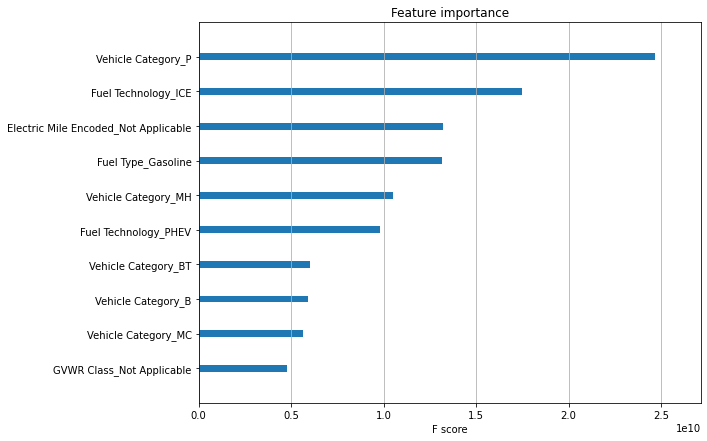

In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))
plot_importance(regressor, importance_type="gain", max_num_features=10, ax=ax)
ax.grid(False, axis="y")  
ax.set_ylabel('')

for text in ax.texts:
    text.set_visible(False)

In [11]:
regressor.save_model("xgboost_model.json")